In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
from sklearn.metrics import confusion_matrix

In [2]:
file_path = 'C:/Users/omidz/health/GeneExpression.2024-10-24.tsv'
gene_expression_data = pd.read_csv(file_path, sep='\t')

In [3]:
print(gene_expression_data.head())


                                   Case      MYCL      MUC1    CDKN2A  \
0                      TARGET-20-PAWZLW -0.324200 -0.693270 -0.625082   
1  TARGET-20-PAYHFV-Sorted-non-leukemic -0.263630 -0.673539 -0.593864   
2                      TARGET-20-PAKRUP -0.308950 -0.682805 -0.579329   
3                      TARGET-40-PARJXU -0.323086 -0.647726  0.282745   
4                      TARGET-40-PARKAF -0.301255 -0.691313 -0.635892   

       NFIB     FGFR2     WWTR1       SMO     FGFR1     MECOM  ...      GAS7  \
0 -0.807782 -0.734493 -0.949618 -0.808640 -0.713402 -0.875245  ... -0.085265   
1 -0.807782 -0.729638 -0.947802 -0.748588  0.885043 -0.905656  ...  1.757275   
2 -0.807782 -0.735557 -0.957638 -0.730741 -0.043344 -0.912328  ...  4.962881   
3 -0.237569  1.545610  3.180541  0.646824  4.930401 -0.879374  ... -0.463772   
4  3.758523 -0.271039  0.549741  1.550541  0.302574 -0.840657  ... -0.437401   

        FES      JAK3      LCP1      VAV1     IKZF1      FLI1     CSF1R  \
0 -0.

In [4]:
gene_expression_clean = gene_expression_data.drop(columns=['Case'])
scaler = StandardScaler()
gene_expression_scaled = scaler.fit_transform(gene_expression_clean)

In [5]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(gene_expression_scaled)
gene_expression_data['Cluster'] = clusters


In [6]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(gene_expression_scaled)

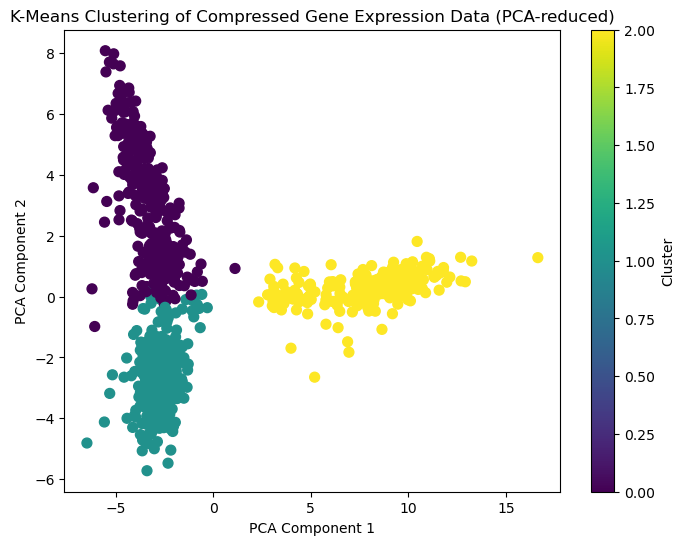

In [7]:
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis', s=50)
plt.title('K-Means Clustering of Compressed Gene Expression Data (PCA-reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [8]:
cluster_means = gene_expression_data.groupby('Cluster').mean(numeric_only=True)
print(cluster_means)

             MYCL      MUC1    CDKN2A      NFIB     FGFR2     WWTR1       SMO  \
Cluster                                                                         
0       -0.080529 -0.211806 -0.255465 -0.246315 -0.223505 -0.181098 -0.424419   
1        0.260771  0.635251  0.613579  0.712821  0.670334  0.767237  0.800636   
2       -0.284618 -0.674251 -0.589097 -0.746024 -0.711487 -0.905598 -0.657455   

            FGFR1     MECOM      MLF1  ...      GAS7       FES      JAK3  \
Cluster                                ...                                 
0       -0.529304 -0.128349 -0.303390  ... -0.443530 -0.498351 -0.495688   
1        0.622351  0.592792  0.748601  ... -0.336240 -0.361322 -0.449939   
2       -0.267512 -0.713829 -0.728859  ...  1.035542  1.139337  1.266231   

             LCP1      VAV1     IKZF1      FLI1     CSF1R      KLF4      MAFB  
Cluster                                                                        
0       -0.490772 -0.522011 -0.513206 -0.482976 -0.40

In [9]:
cluster_std = cluster_means.std(axis=0).sort_values(ascending=False)
print("Top 10 Genes with the highest variability across clusters:")
print(cluster_std.head(10))

Top 10 Genes with the highest variability across clusters:
IKZF1    1.101356
VAV1     1.080710
PTPRC    1.070230
FLI1     1.043510
LCP1     1.040627
RBM15    1.024464
GNA11    1.018263
CDH1     1.015368
LYN      1.009464
PTPRK    1.005499
dtype: float64


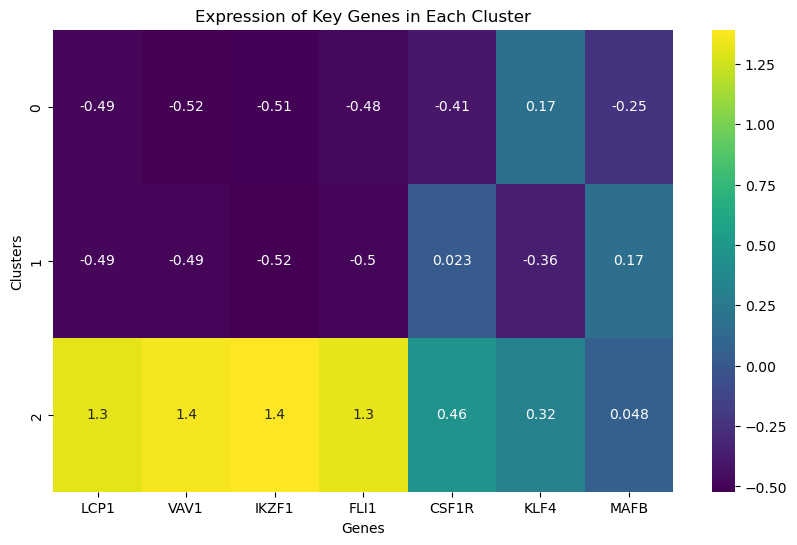

In [10]:
key_genes = ['LCP1', 'VAV1', 'IKZF1', 'FLI1', 'CSF1R', 'KLF4', 'MAFB']
cluster_key_genes = cluster_means[key_genes]
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_key_genes, annot=True, cmap='viridis')
plt.title('Expression of Key Genes in Each Cluster')
plt.xlabel('Genes')
plt.ylabel('Clusters')
plt.show()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(gene_expression_scaled, clusters, test_size=0.2, random_state=42)


In [12]:
lb = LabelBinarizer()
y_train_ohe = lb.fit_transform(y_train)
y_test_ohe = lb.transform(y_test)


In [13]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(gene_expression_scaled.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [15]:
history = model.fit(X_train, y_train_ohe, epochs=100, batch_size=32, validation_data=(X_test, y_test_ohe))


Epoch 1/100
25/25 [==============================] - 2s 25ms/step - loss: 0.2809 - accuracy: 0.8813 - val_loss: 0.0168 - val_accuracy: 0.9950
Epoch 2/100
25/25 [==============================] - 0s 9ms/step - loss: 0.0260 - accuracy: 0.9900 - val_loss: 0.0194 - val_accuracy: 0.9950
Epoch 3/100
25/25 [==============================] - 0s 9ms/step - loss: 0.0108 - accuracy: 0.9962 - val_loss: 0.0242 - val_accuracy: 0.9950
Epoch 4/100
25/25 [==============================] - 0s 9ms/step - loss: 0.0148 - accuracy: 0.9975 - val_loss: 0.0389 - val_accuracy: 0.9950
Epoch 5/100
25/25 [==============================] - 0s 9ms/step - loss: 0.0077 - accuracy: 0.9987 - val_loss: 0.0546 - val_accuracy: 0.9900
Epoch 6/100
25/25 [==============================] - 0s 8ms/step - loss: 0.0043 - accuracy: 0.9987 - val_loss: 0.0469 - val_accuracy: 0.9950
Epoch 7/100
25/25 [==============================] - 0s 8ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0438 - val_accuracy: 0.9900
Epoch 8/100


Epoch 58/100
25/25 [==============================] - 0s 8ms/step - loss: 6.4200e-05 - accuracy: 1.0000 - val_loss: 0.0570 - val_accuracy: 0.9900
Epoch 59/100
25/25 [==============================] - 0s 8ms/step - loss: 0.0038 - accuracy: 0.9987 - val_loss: 0.0668 - val_accuracy: 0.9900
Epoch 60/100
25/25 [==============================] - 0s 9ms/step - loss: 3.7397e-04 - accuracy: 1.0000 - val_loss: 0.0940 - val_accuracy: 0.9850
Epoch 61/100
25/25 [==============================] - 0s 9ms/step - loss: 0.0086 - accuracy: 0.9987 - val_loss: 0.0593 - val_accuracy: 0.9900
Epoch 62/100
25/25 [==============================] - 0s 8ms/step - loss: 1.5232e-04 - accuracy: 1.0000 - val_loss: 0.0737 - val_accuracy: 0.9900
Epoch 63/100
25/25 [==============================] - 0s 8ms/step - loss: 9.9309e-06 - accuracy: 1.0000 - val_loss: 0.0761 - val_accuracy: 0.9900
Epoch 64/100
25/25 [==============================] - 0s 8ms/step - loss: 4.7545e-05 - accuracy: 1.0000 - val_loss: 0.0781 - val_acc

In [16]:
test_loss, test_acc = model.evaluate(X_test, y_test_ohe)
print(f"Test accuracy: {test_acc}")


7/7 [==============================] - 0s 3ms/step - loss: 0.0909 - accuracy: 0.9900
Test accuracy: 0.9900000095367432


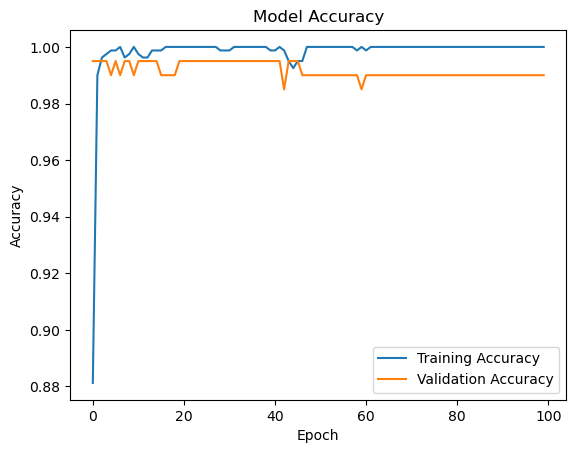

In [17]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

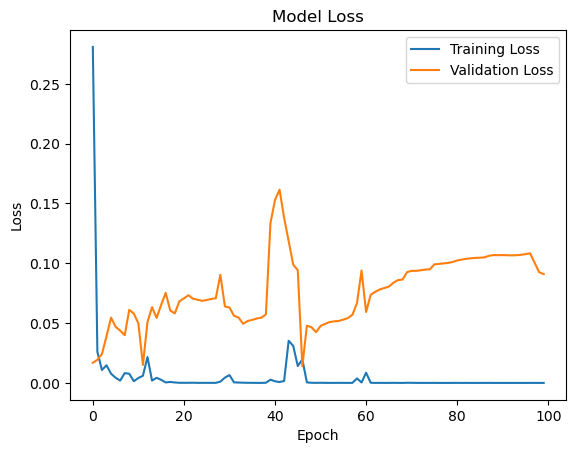

In [18]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [19]:
y_pred = model.predict(X_test)
y_pred_labels = lb.inverse_transform(y_pred)
cm = confusion_matrix(y_test, y_pred_labels)

7/7 [==============================] - 0s 3ms/step


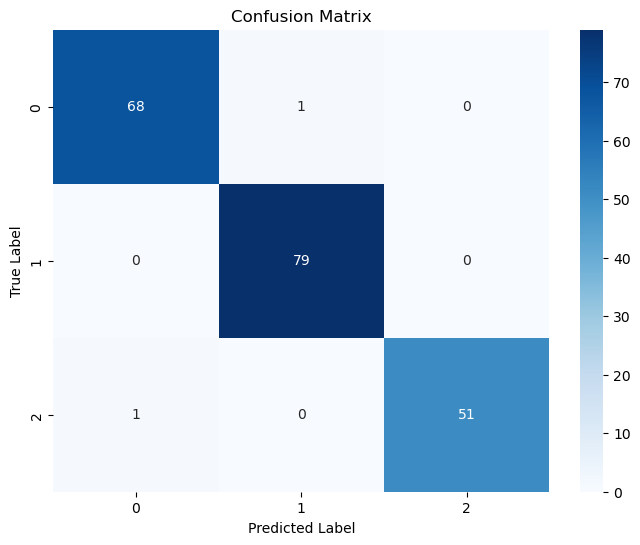

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\omidz\anaconda3\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\omidz\anaconda3\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\omidz\anaconda3\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\omidz\anaconda3\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed b

In [20]:
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()